In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the data


In [2]:
df = pd.read_csv("Data set/mnist_train.csv")

### Visualizing the Data


In [3]:
df.head()

,5,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.608,0.609,0.610,0.611,0.612,0.613,0.614,0.615,0.616,0.617
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df.shape  # (59999, 785)

(59999, 785)

1. **Rows ($59999$)**: This represents the number of samples or images in the dataset. Each row corresponds to one handwritten digit image.

2. **Columns ($785$)**: This represents the features of each sample. The first column is the label (the digit), and the remaining 784 columns represent the pixel values of the $28$ x $28$ image.

- **Labels**: The first column contains the labels, which are the digits (0-9) that the image represents.

- **Pixel** Values: The remaining 784 columns contain the pixel values of the image, flattened into a single row.

Each image in the dataset is a $28$ x $28$ pixel grid, which equals $784$ pixels. When flattened, these pixels are represented as $784$ columns in the DataFrame.


In [5]:
df.iloc[:, 0].value_counts().sort_index()

5
0    5923
1    6742
2    5958
3    6131
4    5842
5    5420
6    5918
7    6265
8    5851
9    5949
Name: count, dtype: int64

### Plotting the images from the dataset


In [1]:
def plot_image(data):
    # Extract the label and the pixel values

    index = np.random.randint(0, len(data))     # Randomly select an index
    label = data.iloc[index, 0]                 # Label is in the first column
    # Pixels are the rest of the columns
    pixels = data.iloc[index, 1:].values
    # Reshape the pixels into a 28x28 array
    image = pixels.reshape(28, 28)

    # Plot the image
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')
    plt.show()


# Plot the image, this will be different each time you run the code
plot_image(df)

NameError: name 'df' is not defined

# Seperate features and labels of train and test data


In [7]:
# Separate the features and labels for the training set
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

test_data = pd.read_csv("Data set/mnist_test.csv")

# Separate the features and labels for the test set
X_test = test_data.iloc[:, 1:].values
y_test = test_data.iloc[:, 0].values

## Normalization and Encoding

$ X\_{normalised} = \frac{X}{255} $ This scales the pixel values to be between 0 and 1

$ y\_{one_hot} = one_hot_encode(y)$ Converts the labels into a binary matrix representation


In [8]:
# Normalize the features to be between 0 and 1
X = X / 255.0
X_test = X_test / 255.0

# Convert labels to one-hot encoding
num_classes = 10
y_one_hot = np.eye(num_classes)[y]

# Model

- **Input Layer**: 784 neurons representing the features of the data.
- **Hidden Layer**: 256 neurons with ReLU activation.
- **Output Layer**: 10 neurons with Softmax activation for classification.

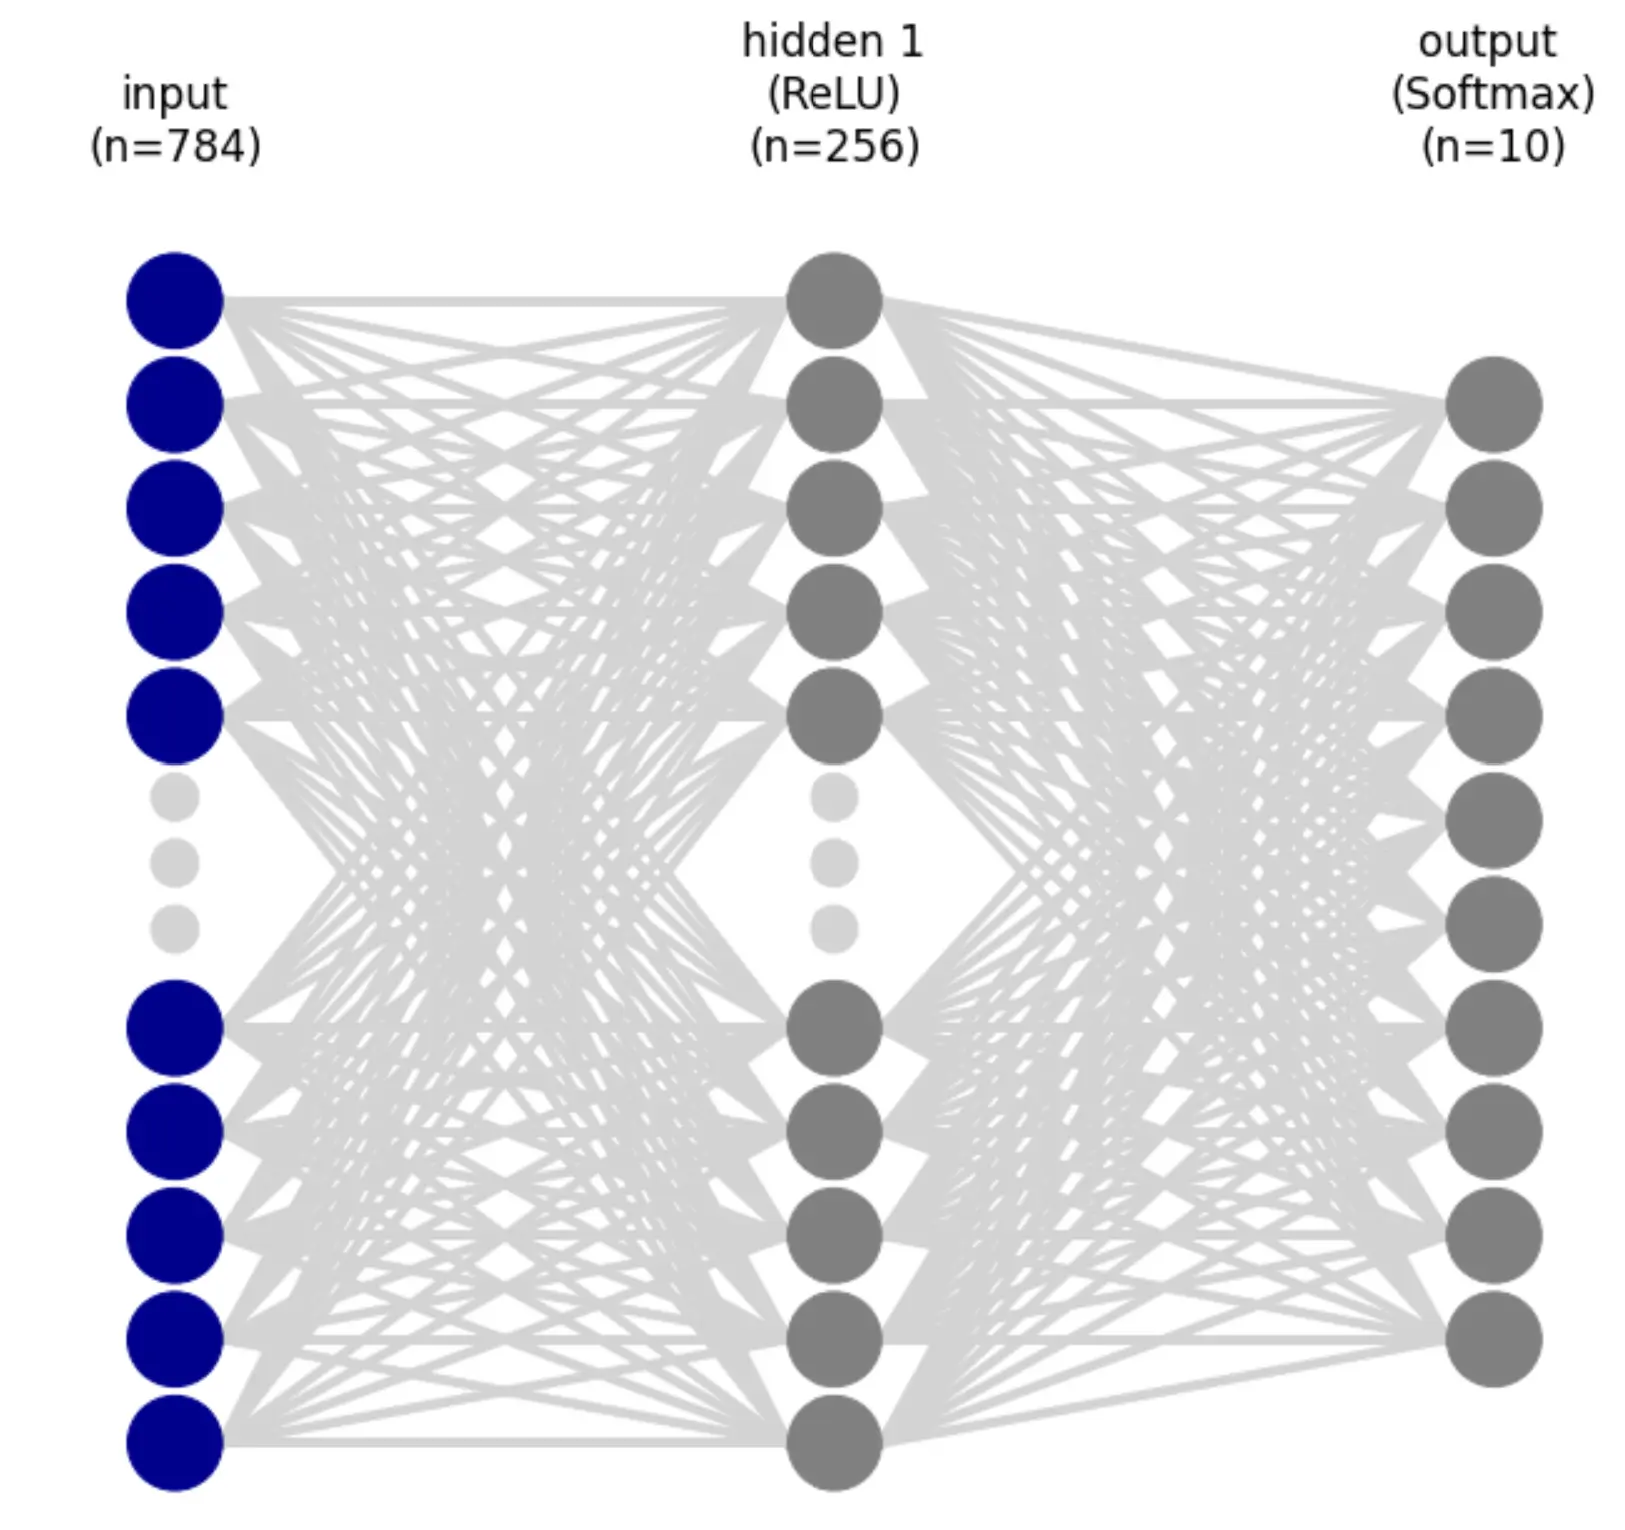


## Initializing Parameter

$ \quad W1 \sim \mathcal{N}(0, 0.001) $

$ \quad b1 = 0 $

$ \quad W2 \sim \mathcal{N}(0, 0.001) $

$ \quad b2 = 0 $


In [9]:
def initialize_parameters(input_size, hidden_size, output_size):
    np.random.seed(42)
    W1 = np.random.randn(input_size, hidden_size) * 0.001
    b1 = np.zeros((1, hidden_size))
    W2 = np.random.randn(hidden_size, output_size) * 0.001
    b2 = np.zeros((1, output_size))
    return W1, b1, W2, b2

### Activation Functions


In [10]:
# Activation functions
def tanh(x):
    return np.tanh(x)


def relu(x):
    return np.maximum(x, 0)


def softmax(x):
    expX = np.exp(x - np.max(x, axis=1, keepdims=True))
    return expX / np.sum(expX, axis=1, keepdims=True)

# Derivative of activation functions


def derivative_tanh(x):
    return (1 - np.power(np.tanh(x), 2))


def derivative_relu(x):
    return np.array(x > 0, dtype=np.float32)

## Cost Function

Measures the error of the model's predictions

$ \text{Cost} = -\frac{1}{m} \sum y \log(A2) $


In [11]:
def cost_function(A2, y):
    m = y.shape[0]  # Number of samples

    # Avoiding division by zero and numerical instability in log
    epsilon = 1e-10
    A2 = np.clip(A2, epsilon, 1 - epsilon)

    # Compute cross-entropy cost
    cost = -1/m * np.sum(y * np.log(A2))

    return cost

## Forward Propagation

Calculates the activations of each layer.

$ Z_1 = XW_1 + b_1$

$ A_1 = \tanh(Z_1)$

$ Z_2 = A_1W_2 + b_2$

$ A_2 = \text{softmax}(Z_2)$


In [12]:
def forward_propagation(X, W1, b1, W2, b2):
    Z1 = np.dot(X, W1) + b1
    A1 = relu(Z1)  # Use tanh activation for hidden layer
    Z2 = np.dot(A1, W2) + b2
    A2 = softmax(Z2)  # Use softmax activation for output layer
    return Z1, A1, Z2, A2

## Backward Propagation

Calculates gradients for updating parameters

$ dZ_2 = A_2 - Y$

$ dW_2 = \frac{1}{m} A_1^T dZ_2$

$ db_2 = \frac{1}{m} \sum dZ_2$

$ dA_1 = dZ_2 W_2^T$

$ dZ_1 = dA_1 \cdot \text{tanh}'(Z_1)$

$ dW_1 = \frac{1}{m} X^T dZ_1$

$ db_1 = \frac{1}{m} \sum dZ_1$


In [13]:
def backward_propagation(X, Y, Z1, A1, A2, W1, W2):
    m = X.shape[0]
    dZ2 = A2 - Y
    dW2 = np.dot(A1.T, dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m
    dA1 = np.dot(dZ2, W2.T)
    dZ1 = dA1 * derivative_relu(Z1)  # Use derivative of relu for hidden layer
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m
    return dW1, db1, dW2, db2

## Update Parameters (Gradient - Descent)

Updates weights and biases using the gradients and learning rate $ \eta $

$W1 = W1 - \eta dW1$

$b1 = b1 - \eta db1$

$W2 = W2 - \eta dW2$

$b2 = b2 - \eta db2$


In [14]:
def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    return W1, b1, W2, b2

# Final Model


In [15]:
def model(X, Y, hidden_size, learning_rate, iterations):
    input_size = X.shape[1]
    output_size = Y.shape[1]
    cost_list = []

    W1, b1, W2, b2 = initialize_parameters(
        input_size, hidden_size, output_size)

    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_propagation(X, W1, b1, W2, b2)
        cost = cost_function(A2, Y)
        dW1, db1, dW2, db2 = backward_propagation(X, Y, Z1, A1, A2, W1, W2)
        W1, b1, W2, b2 = update_parameters(
            W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)

        if i % 10 == 0:
            cost_list.append(cost)
        if i % 100 == 0:
            print(f'Iteration {i} of {iterations}, cost: {cost}')

    return W1, b1, W2, b2, cost_list

## Prediction and Accuracy

Predicts labels and calculates the accuracy of the model.

$ \text{predictions} = \arg\max A2$

$ \text{accuracy} = \frac{\sum (\text{predictions} == y)}{m}$


In [16]:
def predict(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_propagation(X, W1, b1, W2, b2)
    predictions = np.argmax(A2, axis=1)
    return predictions

# Evaluate function


def evaluate_model(X_test, y_test, W1, b1, W2, b2):
    predictions = predict(X_test, W1, b1, W2, b2)
    accuracy = np.mean(predictions == y_test)
    return accuracy


# Train the model
hidden_size = 256
learning_rate = 0.1
iterations = 1000
W1, b1, W2, b2, cost_list = model(
    X, y_one_hot, hidden_size, learning_rate, iterations)

# Predict on the training set
predictions = predict(X, W1, b1, W2, b2)

# Evaluate the model on the training set
train_accuracy = evaluate_model(X, y, W1, b1, W2, b2)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

# Evaluate the model on the test set
test_accuracy = evaluate_model(X_test, y_test, W1, b1, W2, b2)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Iteration 0 of 1000, cost: 2.3025950378132607
Iteration 100 of 1000, cost: 1.860767469971828
Iteration 200 of 1000, cost: 0.6943275744886521
Iteration 300 of 1000, cost: 0.4889515579899397
Iteration 400 of 1000, cost: 0.414187368956531
Iteration 500 of 1000, cost: 0.37485477414555957
Iteration 600 of 1000, cost: 0.34916226593916583
Iteration 700 of 1000, cost: 0.3301269613141737
Iteration 800 of 1000, cost: 0.3148982472006192
Iteration 900 of 1000, cost: 0.3020353272118921
Training Accuracy: 91.70%
Test Accuracy: 91.89%


## Plotting cost function


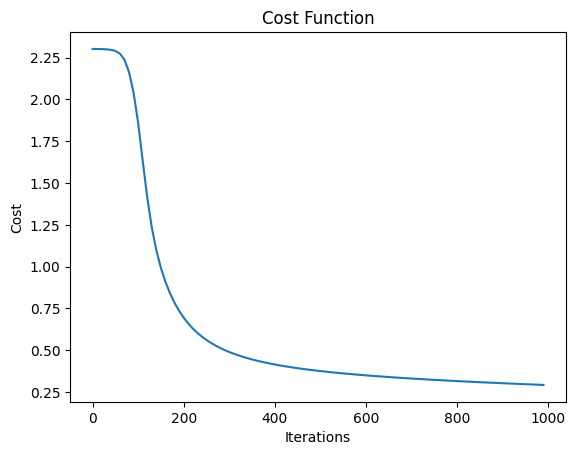

In [17]:
# Plot the cost function
t = np.arange(0, iterations, 10)
plt.plot(t, cost_list)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost Function')
plt.show()

## Vizualizing images and their predictions


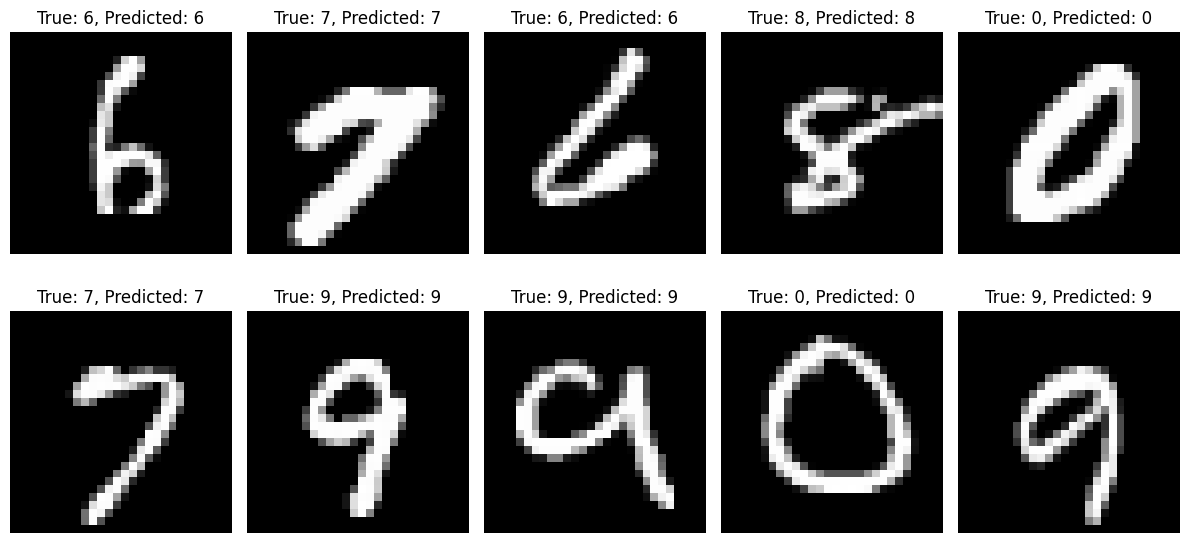

In [18]:
# Function to visualize images and their predictions
def visualize_predictions(X, y_true, y_pred, num_images=10):
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        index = np.random.randint(0, len(X))
        plt.imshow(X[index].reshape(28, 28), cmap='gray')
        plt.title(f"True: {y_true[index]}, Predicted: {y_pred[index]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


# Predictions on test set
predictions_test = predict(X_test, W1, b1, W2, b2)

# Visualize some of the predictions
visualize_predictions(X_test, y_test, predictions_test)